**Coding session: double descent.** In this coding session, we will use the PyTorch framework to explore an interesting empirical phenomenon known as *double descent*.

Double descent is the phenomenon that, in some machine learning settings, the performance-model size relationship has a peak before it decreases further. This contradics the traditional bias-variance tradeoff from statistics. Here's a conceptual depiction of this phenomenon, from [[1]](https://arxiv.org/abs/1812.11118).

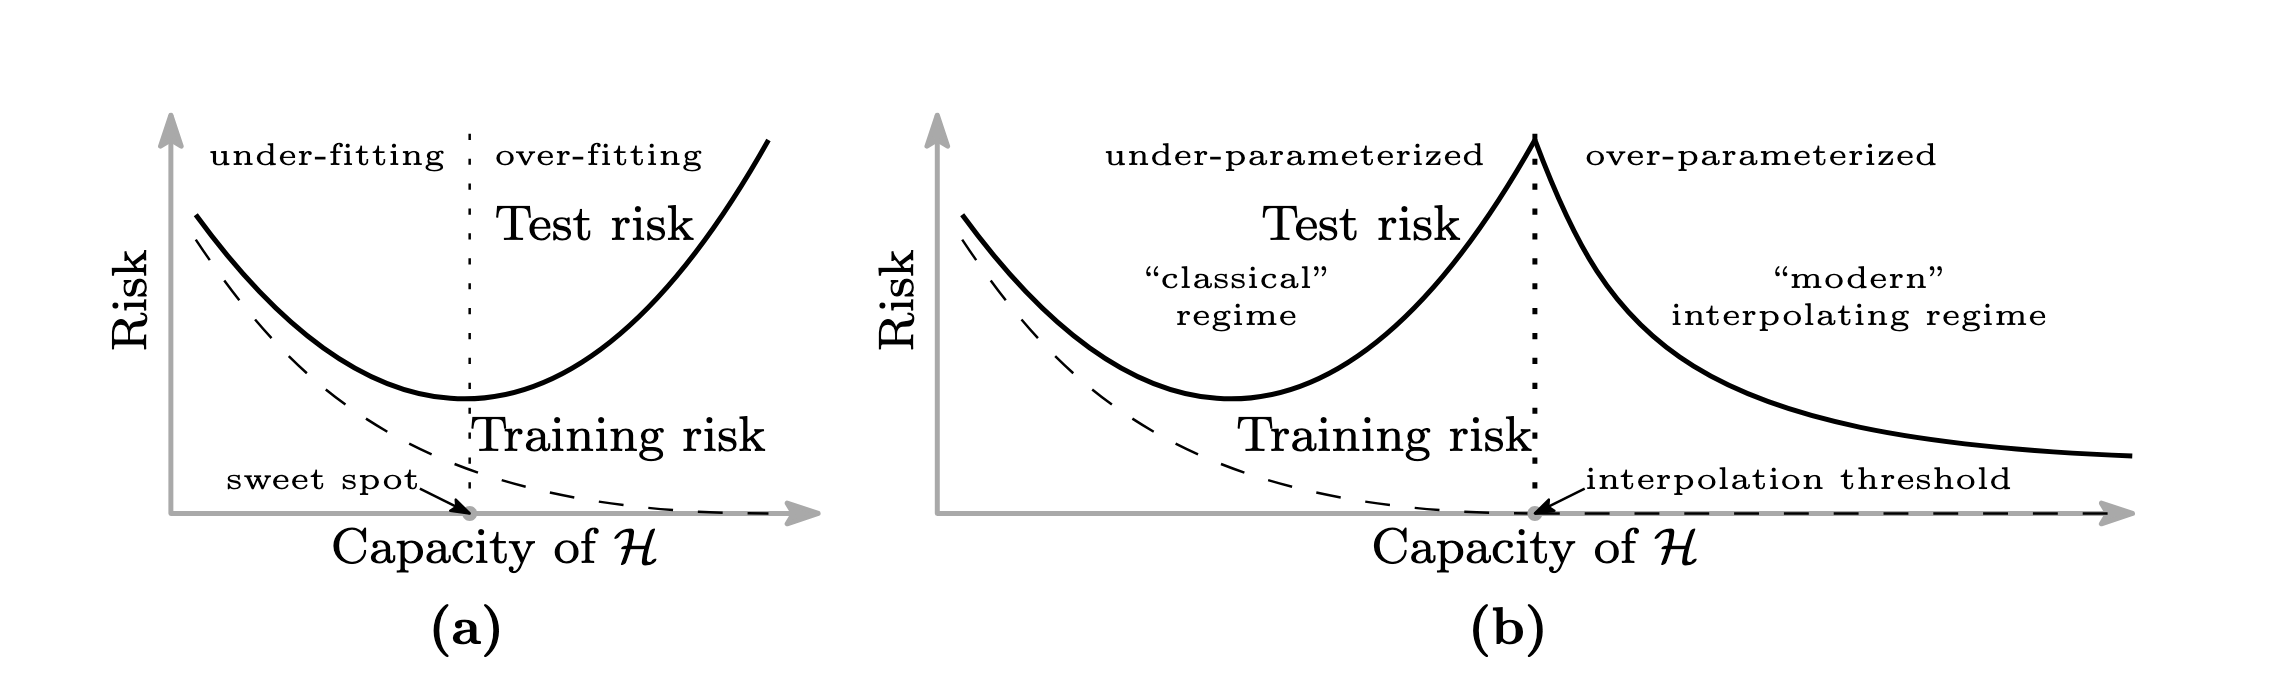

Indeed, this can be observed in various settings, including for [certain linear models](https://arxiv.org/abs/1906.11300), as well as deep models. For this session, our main references will be the following papers which have a more empirical flavor:

*   [Reconciling modern machine learning practice and the bias-variance trade-off by Belkin, Hsu, Ma, and Mandal, 2018](https://arxiv.org/abs/1812.11118)
*   [Deep double descent: where bigger models and more data hurt, by Nakkiran et al, 2019](https://arxiv.org/abs/1912.02292)
*  [Double Descent Demystified: Identifying, Interpreting &
Ablating the Sources of a Deep Learning Puzzle, Schaeffer et al 2023](https://arxiv.org/pdf/2303.14151)

We will start by exploring the phenomenon in the context of fitting polynomials and then move to neural networks. Let's begin by loading some packages.

In [ ]:
import random
import numpy as np
from numpy.polynomial.legendre import legvander
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy.linalg as la

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

**Beginning with polynomials.** Let's consider fitting a polynomial to the following data.

In [ ]:
n = 30
x = np.linspace(-1, 1, n)

def ground_truth(input, beta, deg):
  return legvander(input, deg).dot(beta)

y = ground_truth(x, np.array([1, -1, 2, 20]), 3)

y += 10*np.random.randn(n)

xdense = np.linspace(-1, 1, 100) # points to plot
xdense = np.sort(np.concatenate((x, xdense))) # add in the sample points explicitly
ygt = ground_truth(xdense, np.array([1, -1, 2, 20]), 3)

plt.plot(xdense, ygt, 'grey', label='Ground truth')
plt.plot(x, y, '.g', label='Samples')
plt.title("Noisy observations from a polynomial")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

We'll do linear regression in the basis of Legendre polynomials and plot the solution for different degrees. It's worth noting here that this is an instance of kernel methods (for regression rather than classification).

In [ ]:
degrees = [1, 3, 5, 10, 20, 30, 40, 50, 60]

for deg in degrees:
  # Compute the image of x under the first (d + 1) Legendre polynomials
  A = legvander(x, deg)
  # Take linear regression coefficients for x (under this image) to y
  beta = la.pinv(A).dot(y)

  # Compute predictions
  y_pred = legvander(x, deg).dot(beta)

  # Plot the results
  plt.figure(figsize=(8, 6))
  plt.plot(xdense, ygt, 'grey', label='Ground truth')
  plt.plot(x, y, '.g', label='Samples')
  plt.plot(xdense, legvander(xdense, deg).dot(beta), color='black', label=f'Fitted polynomial')
  plt.ylim(-30, 30)
  plt.legend()
  plt.title("Fitted polynomial, degree " + str(deg))
  plt.xlabel("x")
  plt.ylabel("y")
  plt.grid()
  plt.show()

Observe that we are fitting the polynomial to $n = 30$ training points, and as predicted by classic statistical bounds, when the number of parameters approaches $30$ the fit becomes very bad. However, as the number of parameters goes past $30$, the fitted polynomial actually becomes rather smooth. This is a visual example of the double-descent phenomenon: the polynomials with larger degree actually generalize better than those of lower degree.

Next, let's consider a similar synthetic data example but with a multilayer neural network model. It's important to note here that the double descent phenomenon can be difficult to reproduce -- in fact it's difficult to see double descent on the above dataset. The following dataset works better to visualize it.

In [ ]:
# Create x data points from -1.2 to 1.2
x = np.linspace(-1.2, 1.2, 200)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
n = 20

def ground_truth(z):
  return np.sin(10*z) + 2*z

y = ground_truth(x)

# Calculate y values with noise
x_train = x[np.random.choice(200, size=n, replace=False)]
y_train = ground_truth(x_train) + 0.3 * np.random.randn(n)

# Create the plot
plt.plot(x, ground_truth(x), 'grey', label="Ground truth")  # Training data in blue
plt.plot(x_train, y_train, '.g', label="Training Data", markersize=7)   # Testing data in red
plt.xlabel("x")
plt.ylabel("y")
plt.title("Noisy Data with Train Points")
plt.legend()  # Add a legend to distinguish training and testing data

# Show the plot
plt.show()

# Create PyTorch Datasets
train_dataset = TensorDataset(torch.from_numpy(x_train).float().unsqueeze(1),
                              torch.from_numpy(y_train).float().unsqueeze(1))
test_dataset = TensorDataset(torch.from_numpy(x).float().unsqueeze(1),
                              torch.from_numpy(ground_truth(x)).float().unsqueeze(1))

# Create PyTorch DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Practice PyTorch by filling out the training method in the following neural network module.

In [ ]:
criterion = nn.MSELoss()  # Mean Squared Error loss

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
                          nn.Linear(input_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, hidden_size),
                          nn.ReLU(),
                          nn.Linear(hidden_size, output_size))

    def forward(self, x):
        out = self.model(x)
        return out

    def train(self, train_loader, num_epochs=5000, lr=0.01):
        optimizer = optim.Adam(self.model.parameters(), lr=lr)  # Adam optimizer
        for epoch in range(epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                ## YOUR CODE HERE ## 

            if epoch % 3000 == 0:
              print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.7f}")
              if self.test(x, y) < 10e-6:
                print(f"   ... and converged; exiting")
                return

    def test(self, x_test, y_test):
        with torch.no_grad():  # Disable gradient calculation during inference
            y_pred = self.model(torch.from_numpy(x_test).float().unsqueeze(1))
            loss = criterion(y_pred, torch.from_numpy(y_test).float().unsqueeze(1))  # Calculate loss
        return loss.item()


# Training code
input_size = 1  # Input size (x is 1-dimensional)
output_size = 1  # Output size (y is 1-dimensional)
epochs = 18000  # maximum number of training epochs

In [ ]:
# Need to keep re-setting the seeds in each cell with randomness, or else
# the notebook will become non-deterministic when cells are run more than once
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

train_losses = []
test_losses = []
hidden_sizes_list = [10 + 10*i for i in range(0, 6)]

for hidden_size in hidden_sizes_list:
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.train(train_loader, epochs)
    final_train_loss = model.test(x_train, y_train)
    train_losses.append(final_train_loss)

    # Get predictions from the model
    with torch.no_grad():  # Disable gradient calculation during inference
        y_pred = model.model(torch.from_numpy(x).float().unsqueeze(1))
        loss = criterion(y_pred, torch.from_numpy(y).float().unsqueeze(1))  # Calculate loss

    test_losses.append(loss)

    # Create the plot
    plt.plot(x, y, 'grey', label="Ground truth")
    plt.plot(x_train, y_train, '.g', markersize=10, label="Training Data")
    plt.plot(x, y_pred, label="Neural Network", color="black", linewidth=3)  # Plot the function
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Neural Network Approximation, width = " + str(hidden_size))
    plt.legend()

    # Show the plot
    plt.show()

plt.plot(train_losses)
plt.title("Training losses")
plt.xlabel("width")
plt.ylabel("train MSE")
plt.show()

Notice how for the smaller widths, the network only roughly fits the training data; it doesn't find an interpolating solution. As the network size grows, the model (and algorithm) eventually gains enough capacity to perfectly fit the data, but between points it has rough interpolation Eventually the network still perfectly fits the training data but becomes much more smooth between training points.

Let's plot the training and test loss.

In [ ]:
plt.plot(hidden_sizes_list, train_losses, label="Training Loss")
plt.xlabel("Width")
plt.ylabel("Loss")
plt.title("Training loss vs. width")
plt.legend()
plt.show()

plt.plot(hidden_sizes_list, test_losses, label="Test Loss")
plt.xlabel("Width")
plt.ylabel("Loss")
plt.title("Test loss vs. width")
plt.legend()
plt.show()

The training loss indeed goes down to 0, but the test loss (roughly) displays the double-descent phenomenon.

Finally, let's look at recovering double-descent for a real dataset: MNIST. The following code loads in the MNIST dataset with one-hot encodings of the labels.

In [ ]:
# Need to keep re-setting the seeds in each cell with randomness, or else
# the notebook will become non-deterministic when cells are run more than once
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Flatten the images into 1D vectors (28x28 -> 784)
train_images_flat = train_images.reshape(-1, 28 * 28).astype(np.float32)
test_images_flat = test_images.reshape(-1, 28 * 28).astype(np.float32)

# Optionally, normalize the data to [0, 1]
train_images_flat /= 255.0
test_images_flat /= 255.0

def to_one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = to_one_hot(train_labels)
test_labels_one_hot = to_one_hot(test_labels)

# Create PyTorch Datasets
train_dataset = TensorDataset(torch.from_numpy(train_images_flat).float().unsqueeze(1),
                              torch.from_numpy(train_labels_one_hot).float().unsqueeze(1))
test_dataset = TensorDataset(torch.from_numpy(test_images_flat).float().unsqueeze(1),
                             torch.from_numpy(test_labels_one_hot).float().unsqueeze(1))

# Subset the datasets
train_subset_size = 4000
test_subset_size = 1000
train_subset = torch.utils.data.Subset(train_dataset, range(train_subset_size))
test_subset = torch.utils.data.Subset(test_dataset, range(test_subset_size))

train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=10, shuffle=False)

Now that we have the data, your job is to play with a neural network model to see how the loss behaves as a function of model size and other parameters (for example, you could explore the effect of batch size). The code below is to get you started. Note that double-descent is a somewhat elusive phenomenon, so don't worry if you can't easily find it!

In [ ]:
# Define a fully connected model with one hidden layer
class MNISTNN(nn.Module):
    def __init__(self, hidden_size):
        super(MNISTNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.model(x)

    def train(self, train_loader, num_epochs=50, lr=0.001):
            optimizer = optim.SGD(self.model.parameters(), lr=.1, momentum=0.95)  # Adam optimizer
            for epoch in range(num_epochs):
                for batch_idx, (data, target) in enumerate(train_loader):
                    optimizer.zero_grad()  # Zero the gradients
                    output = self.forward(data)  # Forward pass
                    loss = criterion(output, target)  # Calculate loss
                    loss.backward()  # Backward pass
                    optimizer.step()  # and optimization

    def evaluate_MSE(self, test_loader):
      ## YOUR CODE HERE ##

    def evaluate_accuracy(self, test_loader):
        #self.eval()  # Set the model to evaluation mode
        correct_test = 0
        total_test = 0

        with torch.no_grad():  # No need to compute gradients during evaluation
            for inputs, labels in test_loader:
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        return test_accuracy

In [ ]:
# Need to keep re-setting the seeds in each cell with randomness, or else
# the notebook will become non-deterministic when cells are run more than once
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

train_losses = []
test_losses = []
hidden_sizes_list = [h for h in range(4,130,16)]
#hidden_sizes_list = [4, 20, 36]

for hidden_size in hidden_sizes_list:
    model = MNISTNN(hidden_size)
    model.train(train_loader)
    final_train_loss = model.evaluate_MSE(train_loader)
    train_losses.append(final_train_loss)
    print("get final_train_loss = " + str(final_train_loss.numpy()))

    final_test_loss = model.evaluate_MSE(test_loader)
    test_losses.append(final_test_loss)
    print("get final_test_loss = " + str(final_test_loss.numpy()))


In [ ]:
plt.plot(hidden_sizes_list, train_losses, label="Training Loss")
plt.xlabel("Width")
plt.ylabel("Training MSE")
plt.title("Training MSE vs. width")
plt.legend()
plt.show()

plt.plot(hidden_sizes_list, test_losses, label="Test Loss")
plt.xlabel("Width")
plt.ylabel("Test MSE")
plt.title("Test MSE vs. width")
plt.legend()
plt.show()